<a href="https://colab.research.google.com/github/Karthik-Thota/Cyclone-Intensity-Estimation/blob/main/Cyclone_Project_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"karthikthota16","key":"d581c09311b954406577cd3e9b1eebb0"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d sshubam/insat3d-infrared-raw-cyclone-images-20132021

Dataset URL: https://www.kaggle.com/datasets/sshubam/insat3d-infrared-raw-cyclone-images-20132021
License(s): CC0-1.0
 86% 37.0M/43.2M [00:00<00:00, 96.0MB/s]
100% 43.2M/43.2M [00:00<00:00, 85.8MB/s]


In [3]:
!unzip /content/insat3d-infrared-raw-cyclone-images-20132021.zip

Archive:  /content/insat3d-infrared-raw-cyclone-images-20132021.zip
  inflating: insat3d_for_reference_ds/CYCLONE_DATASET/101.jpeg  
  inflating: insat3d_for_reference_ds/CYCLONE_DATASET/102.jpeg  
  inflating: insat3d_for_reference_ds/CYCLONE_DATASET/106.jpeg  
  inflating: insat3d_for_reference_ds/CYCLONE_DATASET/111.jpeg  
  inflating: insat3d_for_reference_ds/CYCLONE_DATASET/112.jpeg  
  inflating: insat3d_for_reference_ds/CYCLONE_DATASET/115.jpeg  
  inflating: insat3d_for_reference_ds/CYCLONE_DATASET/118.jpeg  
  inflating: insat3d_for_reference_ds/CYCLONE_DATASET/119.jpeg  
  inflating: insat3d_for_reference_ds/CYCLONE_DATASET/128.jpeg  
  inflating: insat3d_for_reference_ds/CYCLONE_DATASET/25.jpeg  
  inflating: insat3d_for_reference_ds/CYCLONE_DATASET/27.jpeg  
  inflating: insat3d_for_reference_ds/CYCLONE_DATASET/28.jpeg  
  inflating: insat3d_for_reference_ds/CYCLONE_DATASET/30(1).jpeg  
  inflating: insat3d_for_reference_ds/CYCLONE_DATASET/30.jpeg  
  inflating: insat3d_for

##First we visualise the data

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
pd.read_csv("/content/insat_3d_ds - Sheet.csv")

,img_name,label
0,25.jpg,25
1,27.jpg,27
2,28.jpg,28
3,30.jpg,30
4,30(1).jpg,30
...,...,...
131,112.jpg,112
132,115.jpg,115
133,118.jpg,118
134,119.jpg,119


In [5]:
import os

# Walk through pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk("/content/insat3d_ir_cyclone_ds"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 1 directories and 0 images in '/content/insat3d_ir_cyclone_ds'.
There are 0 directories and 136 images in '/content/insat3d_ir_cyclone_ds/CYCLONE_DATASET_INFRARED'.


In [6]:
os.mkdir("test_data")

In [7]:
import os
import shutil

source = '/content/insat3d_ir_cyclone_ds/CYCLONE_DATASET_INFRARED'
destination = '/content/test_data'

# gather all files
allfiles = os.listdir(source)

# iterate on all files to move them to destination folder
for f in allfiles[133:]:

    src_path = os.path.join(source, f)
    dst_path = os.path.join(destination, f)
    shutil.move(src_path, dst_path)


In [8]:
#Get the classes drammatically
import pathlib
data_dir=pathlib.Path("/content/insat3d_ir_cyclone_ds")
data_dir

PosixPath('/content/insat3d_ir_cyclone_ds')

In [9]:
#Let visualise our images
import random
def view_random_image(target_dir):
  target_folder=target_dir
  random_image=random.sample(os.listdir(target_folder),10)
  plt.figure(figsize=(10,10))
  for i in range(10):
    img=mpimg.imread(target_folder+"/"+random_image[i])
    plt.subplot(5,2,i+1)
    plt.imshow(img)
    plt.title(random_image[i])
    plt.axis("off");#Default axis is on

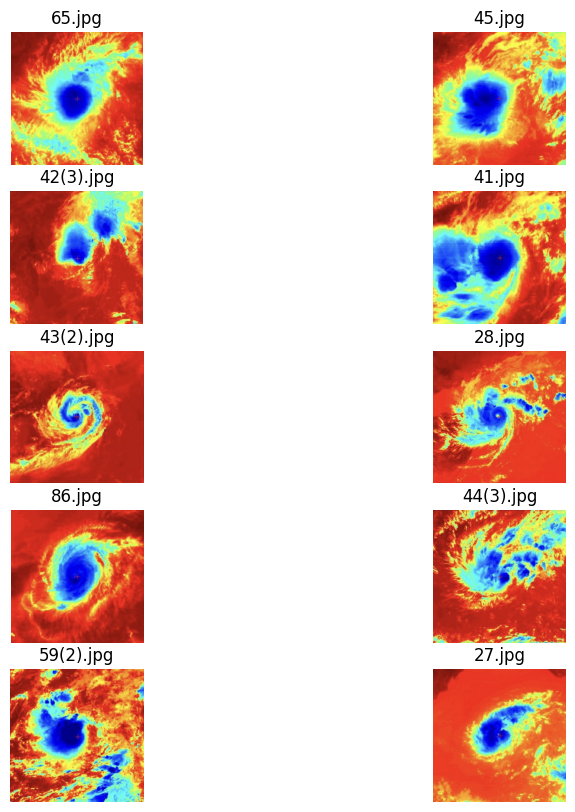

In [10]:
view_random_image("/content/insat3d_ir_cyclone_ds/CYCLONE_DATASET_INFRARED")

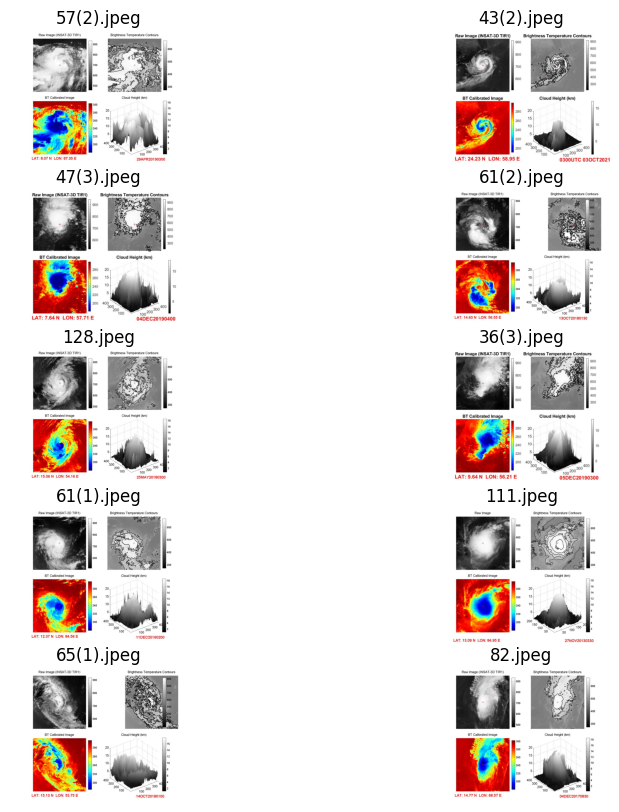

In [11]:
view_random_image("/content/insat3d_for_reference_ds/CYCLONE_DATASET")

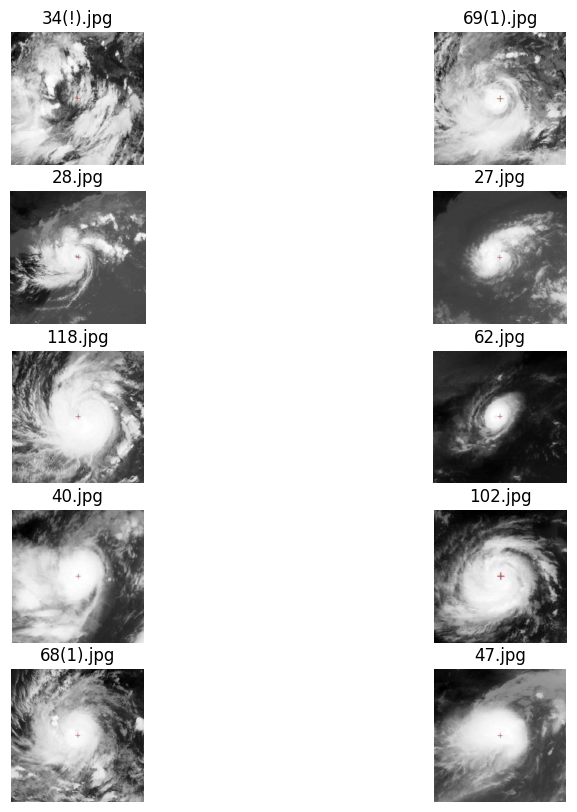

In [12]:
view_random_image("/content/insat3d_raw_cyclone_ds/CYCLONE_DATASET_FINAL")

#Preprocess the data

In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train=pd.read_csv("/content/insat_3d_ds - Sheet.csv")

In [14]:
train_dir="/content/insat3d_ir_cyclone_ds/CYCLONE_DATASET_INFRARED"
train_datagen=ImageDataGenerator(rescale=1./255)
train_data=train_datagen.flow_from_dataframe(train,train_dir,
                                             x_col='img_name',
                                             y_col="label",
                                             subset='training',
                                             target_size=(256,256),
                                             batch_size=16,
                                             class_mode="raw"
                                             )


Found 133 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 3 invalid image filename(s) in x_col="img_name". These filename(s) will be ignored.
  warnings.warn(


#Create a model

In [15]:
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Dropout,Input
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
inputs=Input(shape=(256,256,3))
y=Conv2D(256,3,activation=None, padding="same",kernel_initializer="he_normal",kernel_regularizer=regularizers.L1L2(0.01))(inputs)
y=tf.keras.layers.BatchNormalization()(y)
y=tf.keras.activations.relu(y)
y=Conv2D(256,3,activation=None, padding="same",kernel_initializer="he_normal",kernel_regularizer=regularizers.L1L2(0.01))(y)
y=tf.keras.layers.BatchNormalization()(y)
y=tf.keras.activations.relu(y)
y=MaxPool2D()(y)

y=Conv2D(256,3,activation=None, padding="same",kernel_initializer="he_normal",kernel_regularizer=regularizers.L1L2(0.01))(y)
y=tf.keras.layers.BatchNormalization()(y)
y=tf.keras.activations.relu(y)
y=Conv2D(128,3,activation=None, padding="same",kernel_initializer="he_normal",kernel_regularizer=regularizers.L1L2(0.01))(y)
y=tf.keras.layers.BatchNormalization()(y)
y=tf.keras.activations.relu(y)
y=MaxPool2D()(y)

y=Conv2D(128,3,activation=None, padding="same",kernel_initializer="he_normal",kernel_regularizer=regularizers.L1L2(0.01))(y)
y=tf.keras.layers.BatchNormalization()(y)
y=tf.keras.activations.relu(y)
y=Conv2D(64,3,activation=None, padding="same",kernel_initializer="he_normal",kernel_regularizer=regularizers.L1L2(0.01))(y)
y=tf.keras.layers.BatchNormalization()(y)
y=tf.keras.activations.relu(y)
y=MaxPool2D()(y)

y=Conv2D(64,3,activation=None, padding="same",kernel_initializer="he_normal",kernel_regularizer=regularizers.L1L2(0.01))(y)
y=tf.keras.layers.BatchNormalization()(y)
y=tf.keras.activations.relu(y)
y=Conv2D(32,3,activation=None, padding="same",kernel_initializer="he_normal",kernel_regularizer=regularizers.L1L2(0.01))(y)
y=tf.keras.layers.BatchNormalization()(y)
y=tf.keras.activations.relu(y)
y=MaxPool2D()(y)

y=Conv2D(32,3,activation=None, padding="same",kernel_initializer="he_normal",kernel_regularizer=regularizers.L1L2(0.01))(y)
y=tf.keras.layers.BatchNormalization()(y)
y=tf.keras.activations.relu(y)
y=Conv2D(16,3,activation=None, padding="same",kernel_initializer="he_normal",kernel_regularizer=regularizers.L1L2(0.01))(y)
y=tf.keras.layers.BatchNormalization()(y)
y=tf.keras.activations.relu(y)
y=MaxPool2D()(y)

y= Flatten()(y)
outputs=Dense(1,activation='linear')(y)
model_1=Model(inputs=inputs,outputs=outputs)

In [16]:
model_1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 256, 256, 256)       │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256, 256, 256)       │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 256, 256, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 256, 256, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256, 256, 256)       │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 256, 256, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 128, 128, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128, 128, 256)       │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 128, 128, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 128)       │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128, 128, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 64)          │          73,7

 Total params: 1,778,961 (6.79 MB)

 Trainable params: 1,776,497 (6.78 MB)

 Non-trainable params: 2,464 (9.62 KB)

In [18]:
model_1.compile(loss=tf.keras.losses.mse,
                optimizer=tf.keras.optimizers.Adam(0.002),
                metrics=["mse"])
early_stopping=tf.keras.callbacks.EarlyStopping(monitor="loss",patience=10,mode='min')

In [19]:
history_1=model_1.fit(train_data,
                      epochs=50,callbacks=[early_stopping])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 100s 4s/step - loss: 3465.9321 - mse: 2979.1401
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 706ms/step - loss: 1796.4554 - mse: 1298.7373
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 703ms/step - loss: 947.0904 - mse: 443.4838
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 713ms/step - loss: 915.3519 - mse: 410.2348
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 715ms/step - loss: 847.4784 - mse: 343.4682
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 718ms/step - loss: 790.8072 - mse: 289.2564
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 729ms/step - loss: 775.7758 - mse: 277.3768
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 732ms/step - loss: 768.0994 - mse: 273.3604
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 744ms/step - loss: 721.6964 - mse: 230.8559
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 743ms/step - loss: 673.1276 - mse: 186.3530
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 751ms/step - loss: 623.1247 - mse: 140.7143
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 730ms/step - loss: 631.9083 - mse: 154.0561
Epoch 1

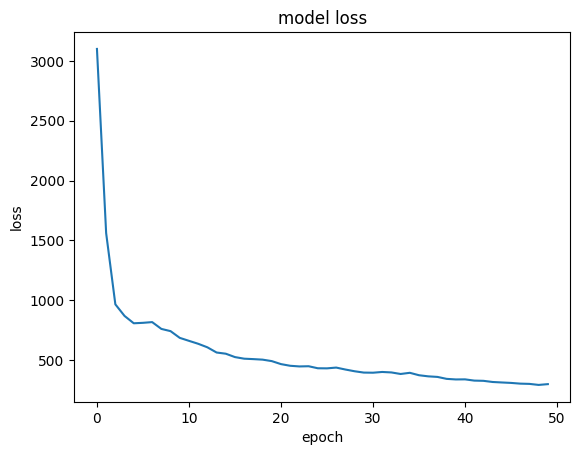

In [20]:
plt.plot(history_1.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [21]:
def load_and_prep_image(filename, img_shape=256):

  img = tf.io.read_file(filename)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.resize(img, size = [img_shape, img_shape])
  img = img/255.
  return img

In [22]:
def pred_and_plot(model, filename):
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

# Plot the image and predicted value
  plt.imshow(img)
  plt.title(f"Prediction: {pred}")
  plt.axis(False);

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


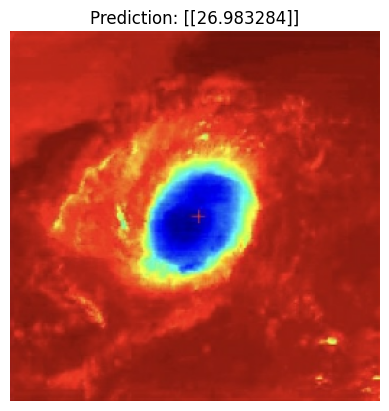

In [24]:
pred_and_plot(model_1,"/content/test_data/35(1).jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


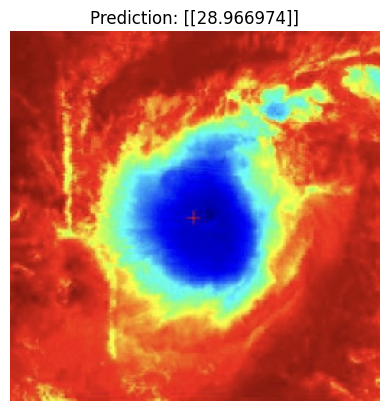

In [25]:
pred_and_plot(model_1,"/content/test_data/111.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


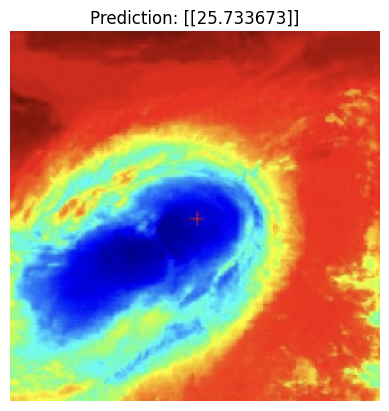

In [26]:
pred_and_plot(model_1,"/content/test_data/44(1).jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


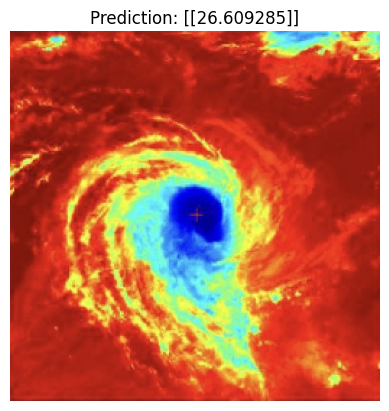

In [27]:
pred_and_plot(model_1,"/content/insat3d_ir_cyclone_ds/CYCLONE_DATASET_INFRARED/69.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


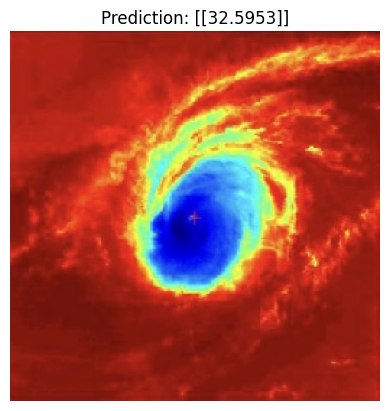

In [28]:
pred_and_plot(model_1,"/content/insat3d_ir_cyclone_ds/CYCLONE_DATASET_INFRARED/85(2).jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


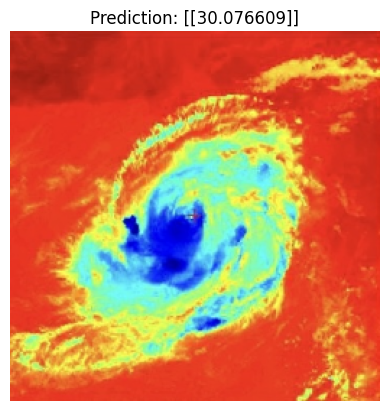

In [29]:
pred_and_plot(model_1,"/content/insat3d_ir_cyclone_ds/CYCLONE_DATASET_INFRARED/94.jpg")